In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy
import numpy as np
np.set_printoptions(threshold=33500)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
from collections import OrderedDict
import fiona
from matplotlib.path import Path
import math

In [2]:
incidents = pd.read_csv('unique_fires.csv')
incidents = incidents[incidents['Fire Name']=='AUGUST COMPLEX'] #here we filter out August Complex
incidents # these are submitted in local time

inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
incidents

,Incident Number,Fire Name,First Day,Last Day,Lat Fire,Lon Fire
1088,11843929.0,AUGUST COMPLEX,2020-08-17 13:44:00,2020-11-11,39.659444,-122.808889


In [3]:
viirs_all = pd.read_csv('merged_viirs.csv', dtype = {'satellite': str,'version': str, 'type': str})
viirs_all

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,46.145030,-114.230690,301.50,0.40,0.60,2019-12-04,842,1,VIIRS,n,2.0NRT,266.30,1.30,N,NaN
1,42.689530,-111.592030,309.10,0.55,0.51,2019-12-04,842,1,VIIRS,n,2.0NRT,270.90,8.00,N,NaN
2,47.817650,-103.056590,296.60,0.42,0.38,2019-12-04,842,1,VIIRS,n,2.0NRT,269.20,0.60,N,NaN
3,45.846410,-105.521350,297.80,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,0.80,N,NaN
4,45.842090,-105.516050,306.40,0.47,0.40,2019-12-04,842,1,VIIRS,n,2.0NRT,272.00,2.20,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065362,39.142639,-121.509666,344.93,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,286.05,6.97,D,0.0
1065363,39.143078,-121.504829,328.83,0.41,0.45,2020-12-31,2124,N,VIIRS,n,1,284.42,4.39,D,0.0
1065364,38.063091,-121.160683,328.92,0.42,0.45,2020-12-31,2124,N,VIIRS,n,1,282.11,2.19,D,0.0
1065365,38.223763,-121.081375,325.87,0.42,0.46,2020-12-31,2124,N,VIIRS,n,1,280.99,2.84,D,0.0


In [4]:
#get the size of the resulting dataframe
df_size = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    for day in dates:
        viirs_sub = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        df_size = df_size + len(np.unique(viirs_sub['acq_time']))
print(df_size)

1339


-122.8088889 39.6594444
2020-08-18 800
REPEATS 1 1
0 1
0


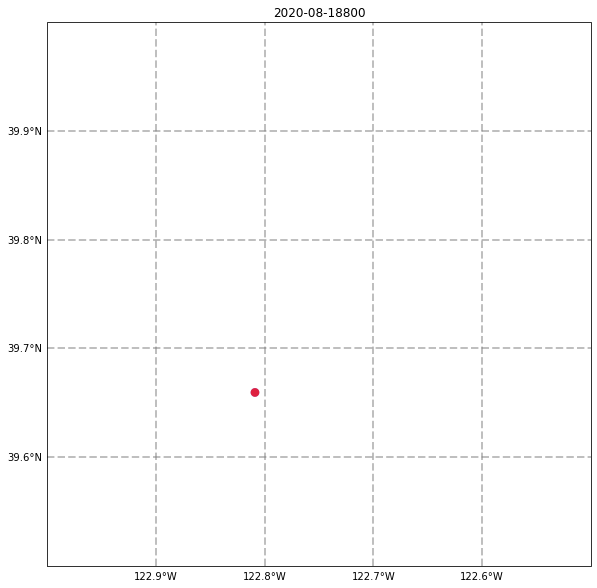

2020-08-18 806
REPEATS 1 1
0 1
0
2020-08-18 854
Time for recursive call
REPEATS 13 13
12 13
12


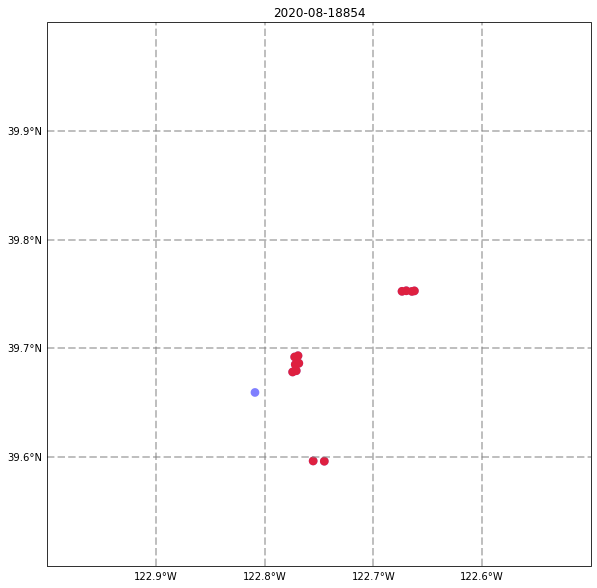

2020-08-18 900
REPEATS 13 13
0 13
0
2020-08-18 942
REPEATS 13 13
0 13
0
2020-08-18 948
Time for recursive call
REPEATS 56 56
43 56
43


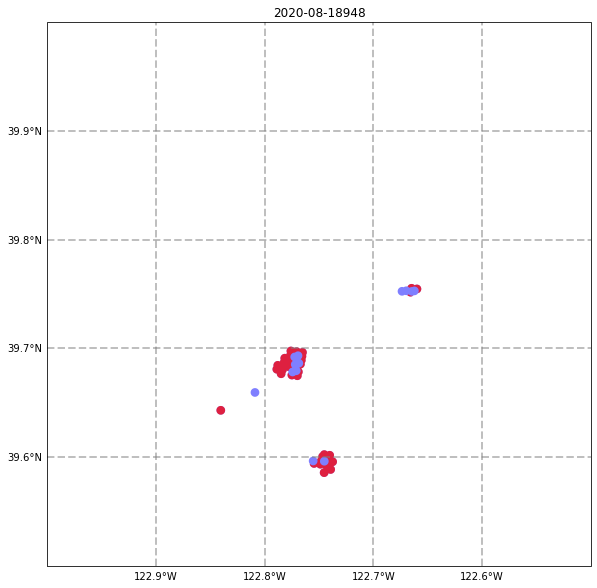

2020-08-18 1036
REPEATS 70 70
14 70
14


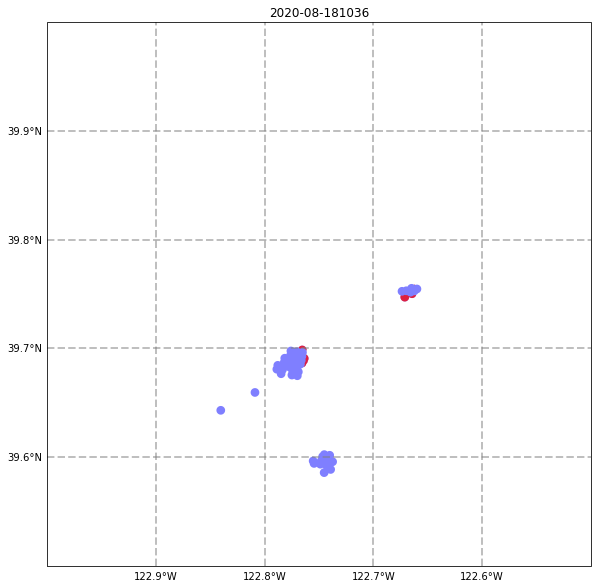

2020-08-18 1124
REPEATS 70 70
0 70
0
2020-08-18 1836
REPEATS 70 70
0 70
0
2020-08-18 1842
REPEATS 70 70
0 70
0
2020-08-18 1924
REPEATS 70 70
0 70
0
2020-08-18 1930
REPEATS 70 70
0 70
0
2020-08-18 2018
REPEATS 131 131
61 131
61


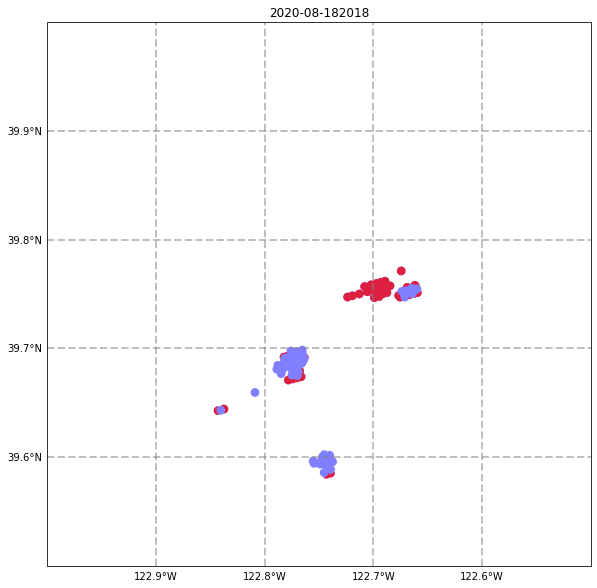

2020-08-18 2106
REPEATS 174 174
43 174
43


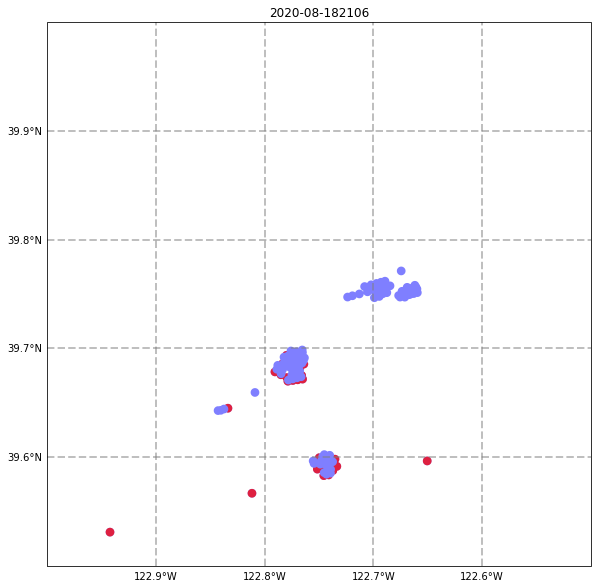

2020-08-18 2112
REPEATS 174 174
0 174
0
2020-08-18 2200
REPEATS 198 198
24 198
24


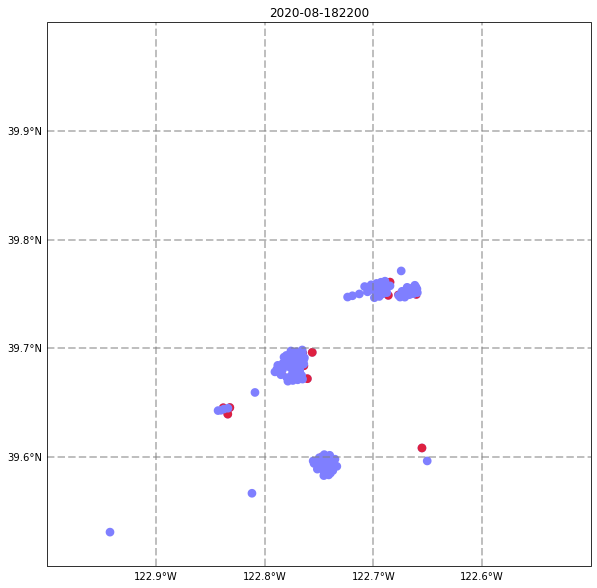

2020-08-19 742
REPEATS 198 198
0 198
0
2020-08-19 748
REPEATS 198 198
0 198
0
2020-08-19 836
REPEATS 198 198
0 198
0
2020-08-19 842
REPEATS 198 198
0 198
0
2020-08-19 924
REPEATS 198 198
0 198
0
2020-08-19 930
Time for recursive call
REPEATS 1145 1095
947 1145
947


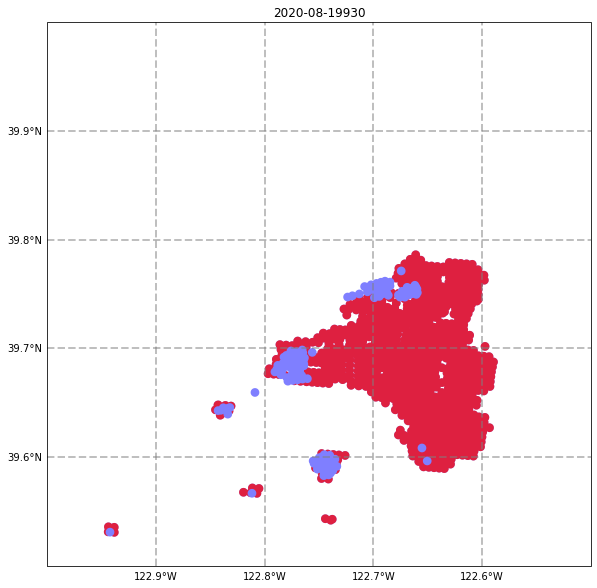

2020-08-19 1012
REPEATS 1145 1095
0 1145
0
2020-08-19 1018
Time for recursive call
REPEATS 2396 2299
1251 2396
1251


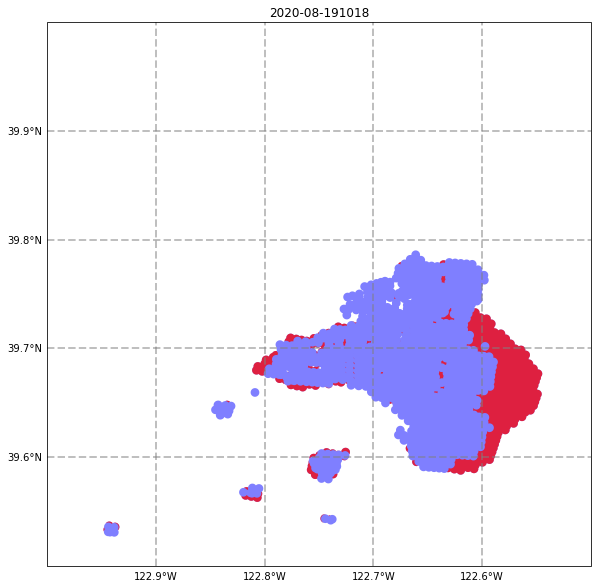

2020-08-19 1106
REPEATS 3524 3360
1128 3524
1128


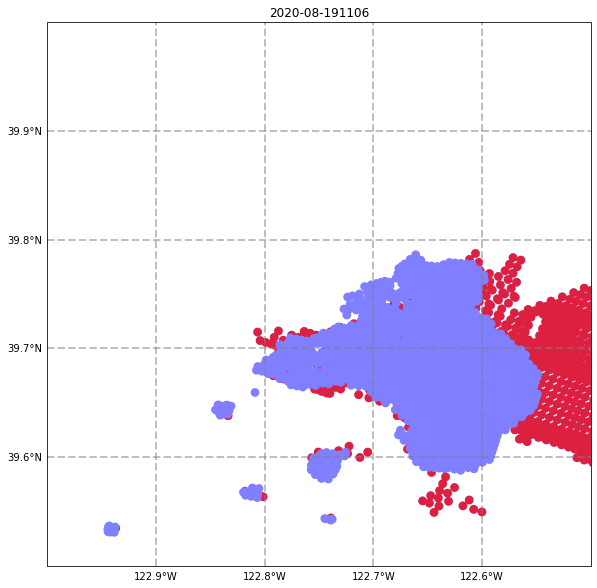

2020-08-19 1818
REPEATS 3524 3360
0 3524
0
2020-08-19 1906
REPEATS 3524 3360
0 3524
0
2020-08-19 1912
REPEATS 3524 3360
0 3524
0
2020-08-19 1954
REPEATS 3524 3360
0 3524
0
2020-08-19 2000
REPEATS 3855 3667
331 3855
331


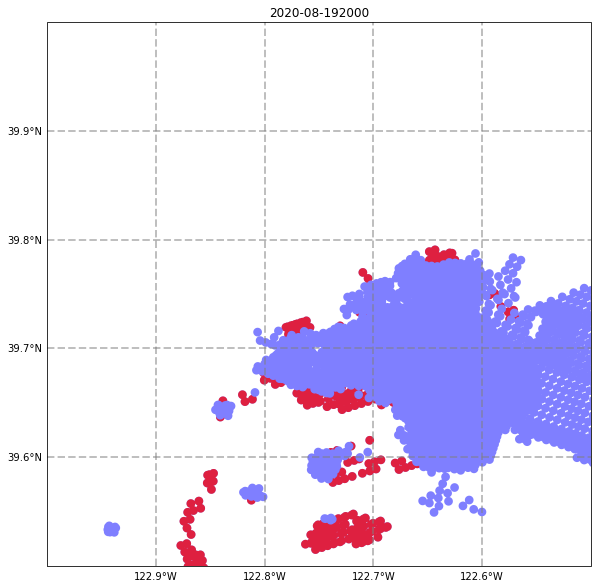

2020-08-19 2048
REPEATS 4127 3909
272 4127
272


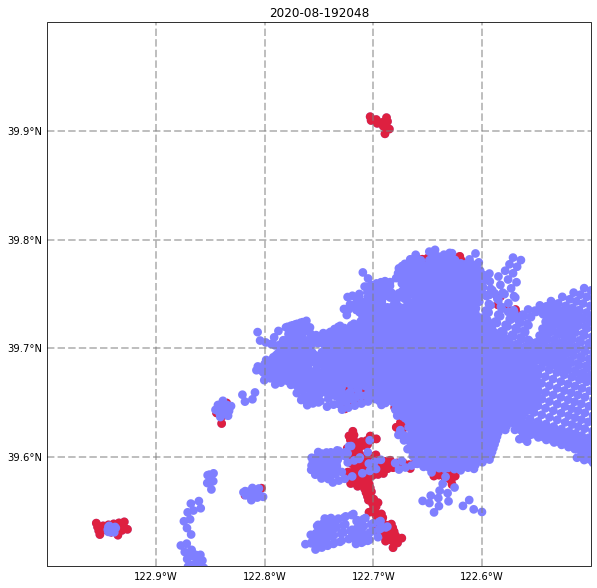

2020-08-19 2054
REPEATS 4127 3909
0 4127
0
2020-08-19 2136
REPEATS 4127 3909
0 4127
0
2020-08-19 2142
REPEATS 4451 4205
324 4451
324


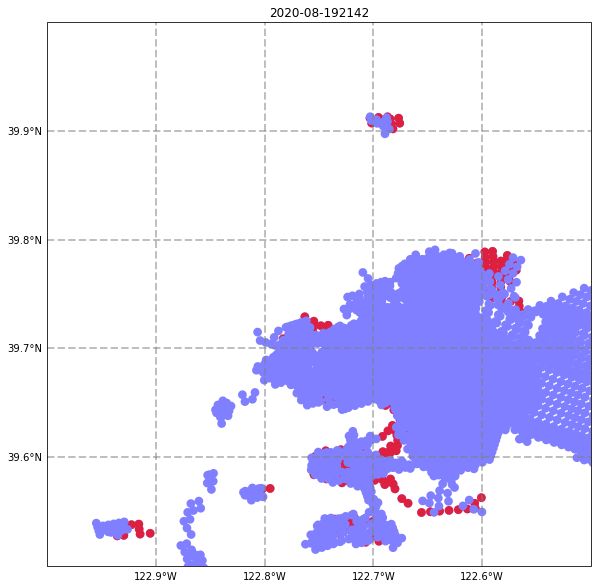

2020-08-20 730
REPEATS 4451 4205
0 4451
0
2020-08-20 818
REPEATS 4451 4205
0 4451
0
2020-08-20 906
REPEATS 5709 5300
1258 5709
1258


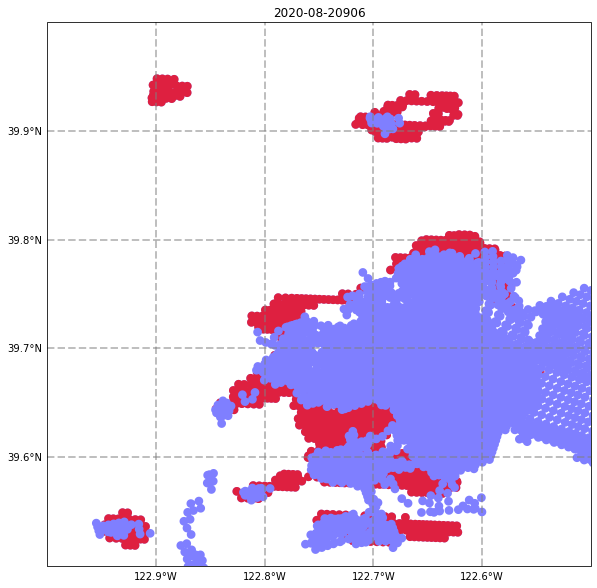

2020-08-20 912
REPEATS 5709 5300
0 5709
0
2020-08-20 954
REPEATS 5709 5300
0 5709
0
2020-08-20 1000
REPEATS 7262 6626
1553 7262
1553


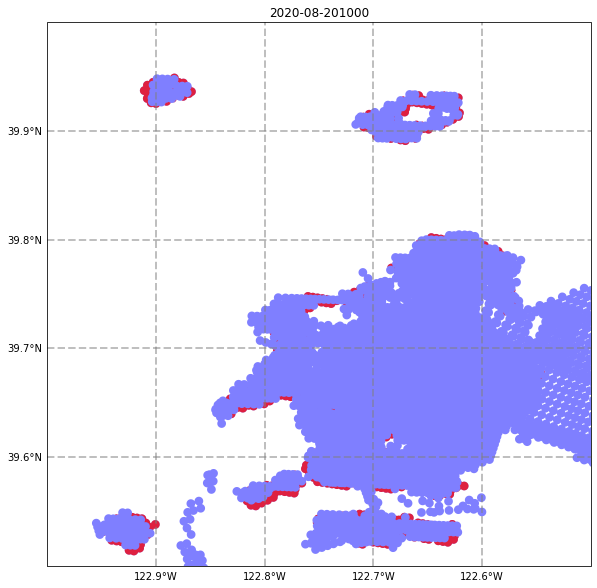

2020-08-20 1048
REPEATS 8404 7561
1142 8404
1142


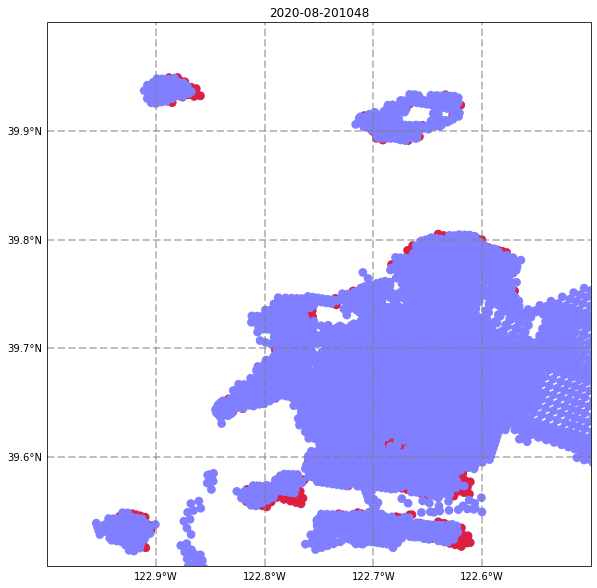

2020-08-20 1848
REPEATS 8404 7561
0 8404
0
2020-08-20 1936
REPEATS 8404 7561
0 8404
0
2020-08-20 1942
REPEATS 8404 7561
0 8404
0
2020-08-20 2030
REPEATS 9168 8181
764 9168
764


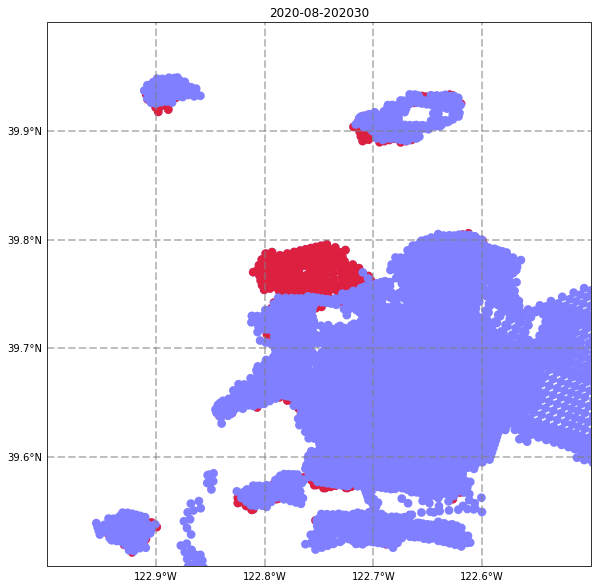

2020-08-20 2118
REPEATS 9168 8181
0 9168
0
2020-08-20 2124
REPEATS 9996 8862
828 9996
828


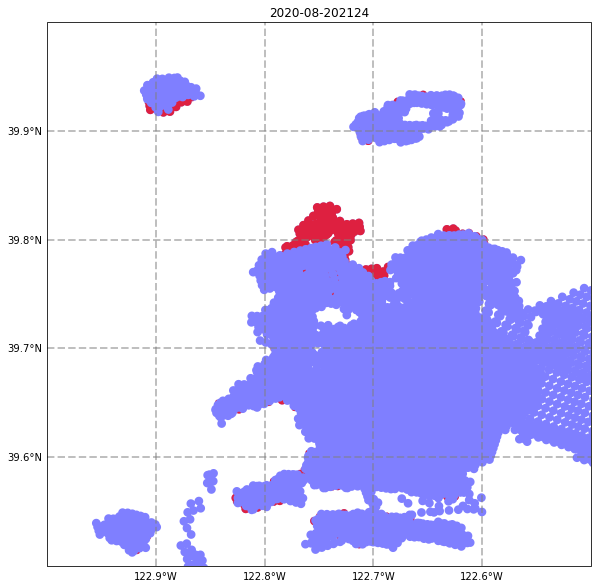

2020-08-20 2212
REPEATS 10543 9279
547 10543
547


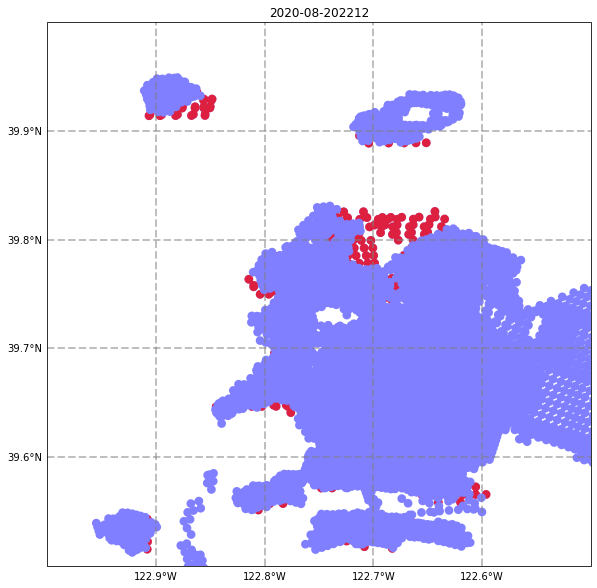

2020-08-21 754
REPEATS 10543 9279
0 10543
0
2020-08-21 800
REPEATS 10543 9279
0 10543
0
2020-08-21 848
REPEATS 10544 9280
1 10544
1


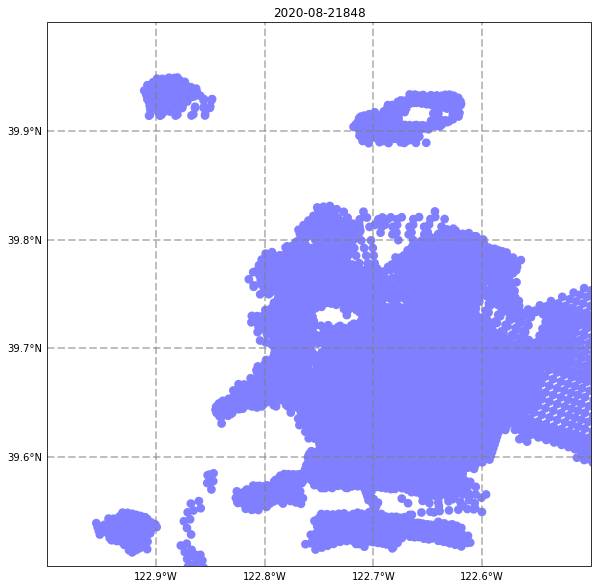

2020-08-21 854
REPEATS 10544 9280
0 10544
0
2020-08-21 936
REPEATS 10544 9280
0 10544
0
2020-08-21 942
REPEATS 11641 10144
1097 11641
1097


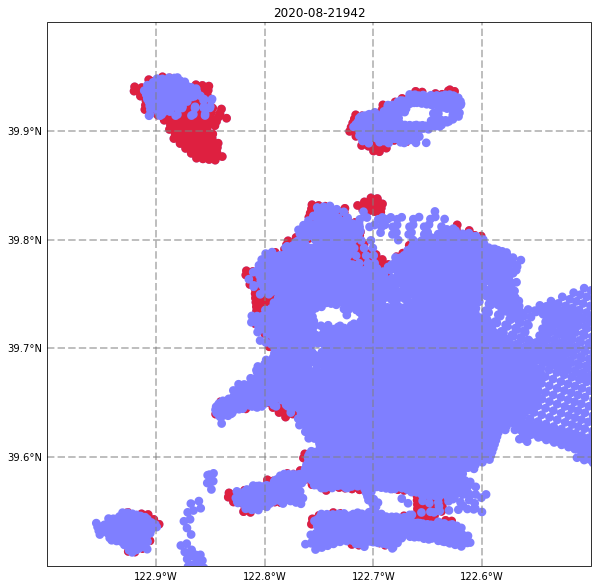

2020-08-21 1030
REPEATS 12677 10928
1036 12677
1036


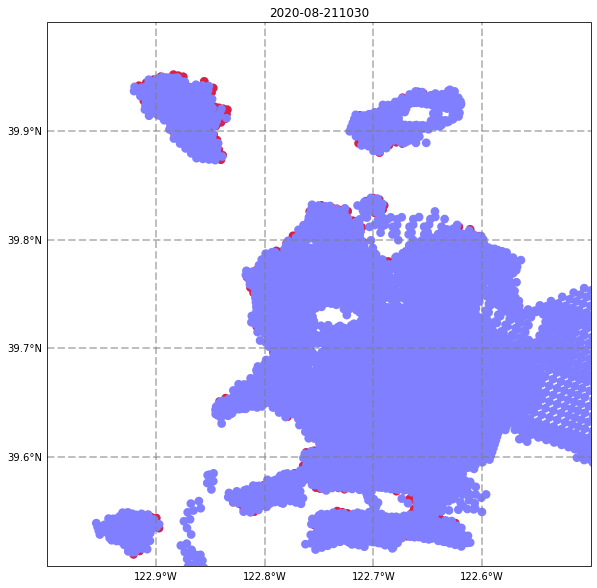

2020-08-21 1118
REPEATS 12677 10928
0 12677
0
2020-08-21 1830
REPEATS 12677 10928
0 12677
0
2020-08-21 1918
REPEATS 12677 10928
0 12677
0
2020-08-21 1924
REPEATS 12677 10928
0 12677
0
2020-08-21 2006
REPEATS 12677 10928
0 12677
0
2020-08-21 2012
REPEATS 13093 11256
416 13093
416


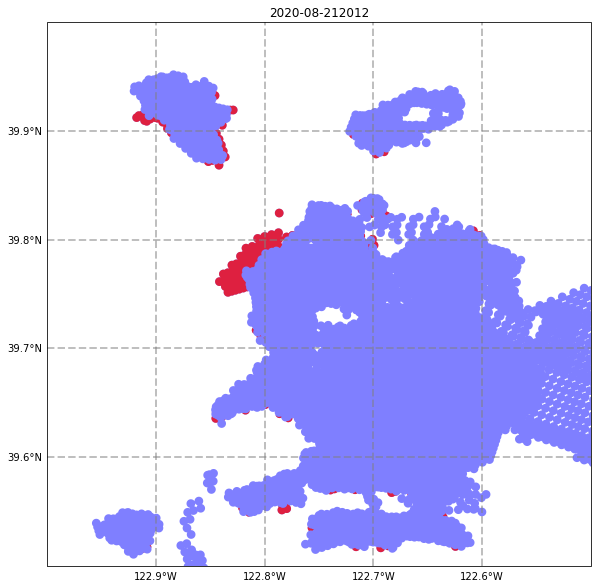

2020-08-21 2100
REPEATS 13777 11792
684 13777
684


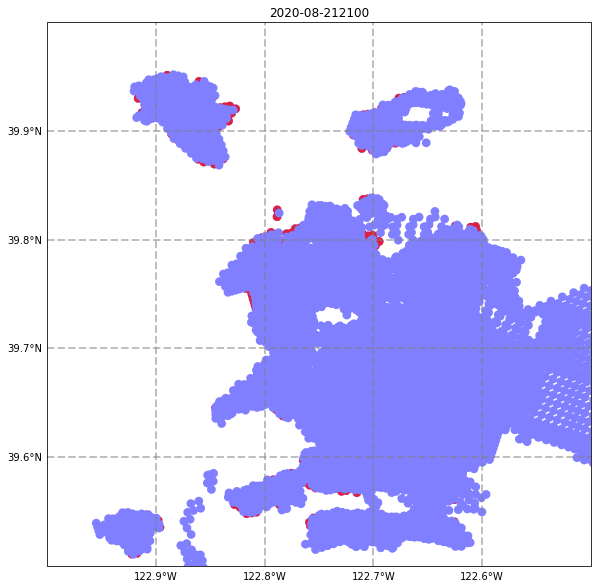

2020-08-21 2106
REPEATS 13777 11792
0 13777
0
2020-08-21 2148
REPEATS 13777 11792
0 13777
0
2020-08-21 2154
REPEATS 14247 12154
470 14247
470


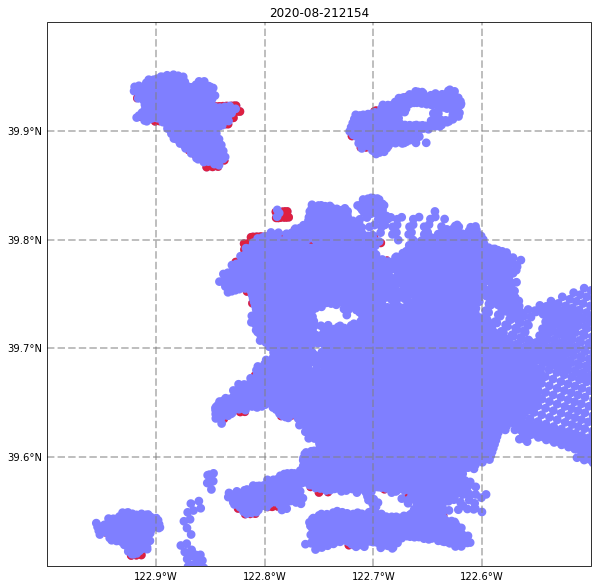

2020-08-22 736
REPEATS 14247 12154
0 14247
0
2020-08-22 742
REPEATS 14247 12154
0 14247
0
2020-08-22 830
REPEATS 14247 12154
0 14247
0
2020-08-22 918
REPEATS 14247 12154
0 14247
0
2020-08-22 924
REPEATS 14798 12589
551 14798
551


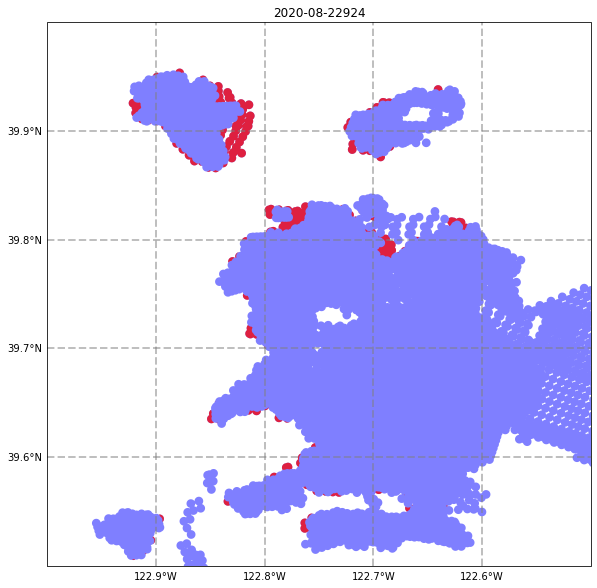

2020-08-22 1006
REPEATS 14798 12589
0 14798
0
2020-08-22 1012
REPEATS 15722 13249
924 15722
924


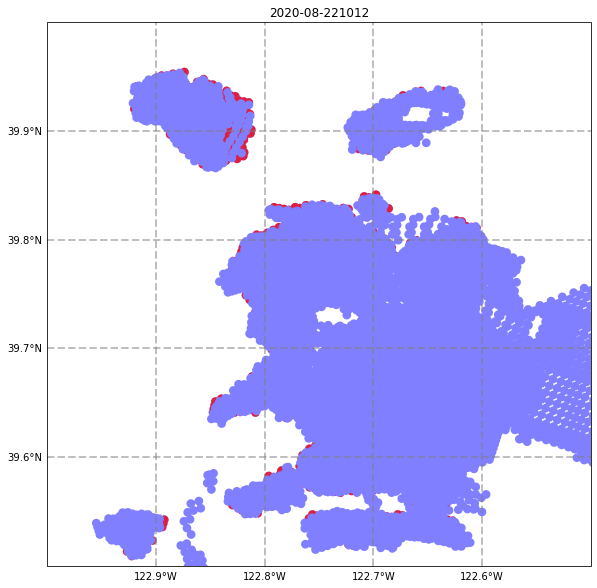

2020-08-22 1100
REPEATS 16172 13589
450 16172
450


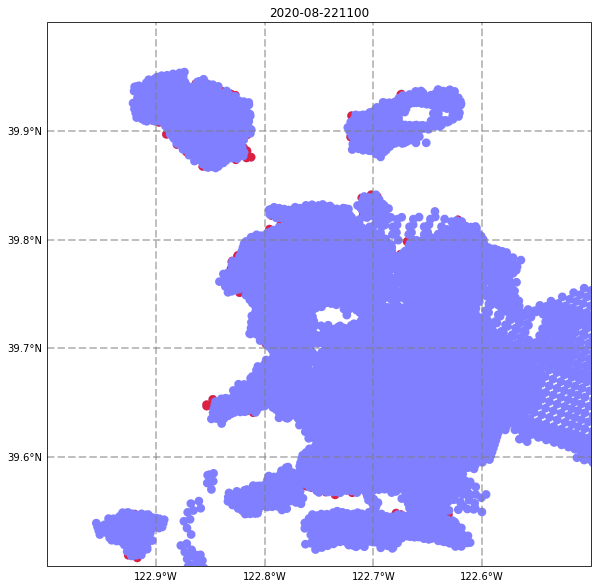

2020-08-22 1900
REPEATS 16172 13589
0 16172
0
2020-08-22 1906
REPEATS 16172 13589
0 16172
0
2020-08-22 1948
REPEATS 16172 13589
0 16172
0
2020-08-22 1954
REPEATS 16308 13691
136 16308
136


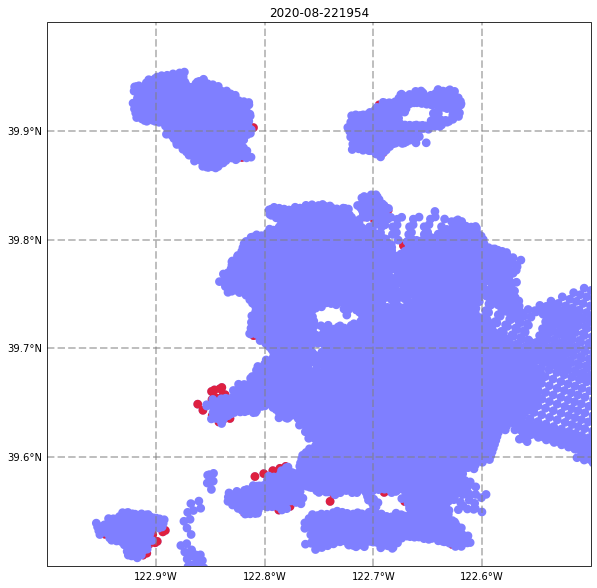

2020-08-22 2042
REPEATS 16691 13984
383 16691
383


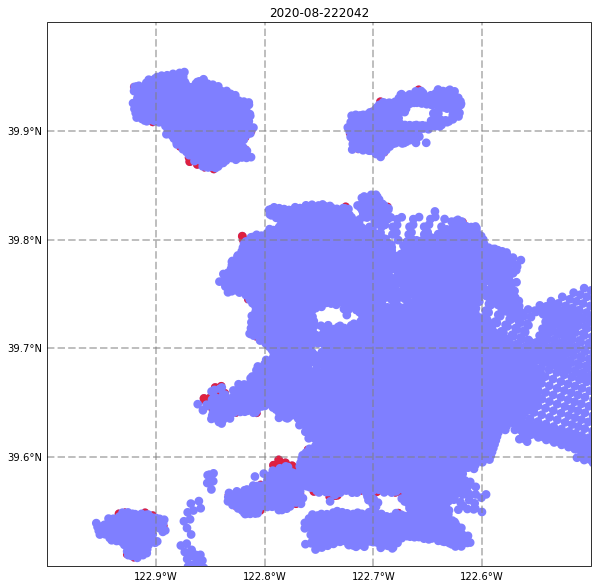

2020-08-22 2048
REPEATS 16691 13984
0 16691
0
2020-08-22 2130
REPEATS 16691 13984
0 16691
0
2020-08-22 2136
REPEATS 17067 14254
376 17067
376


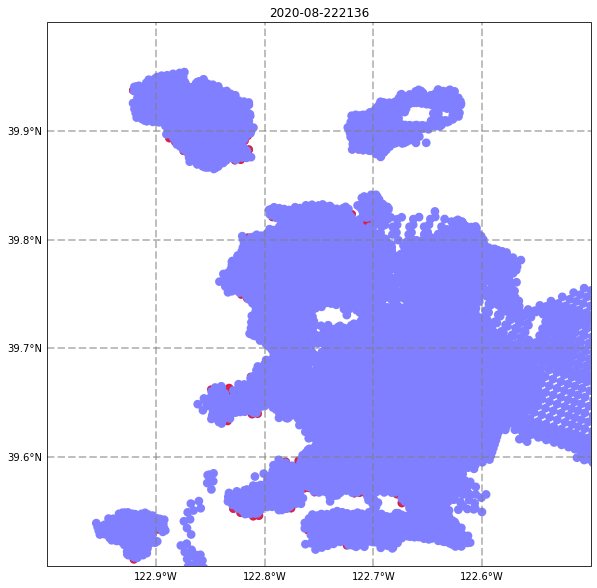

2020-08-23 806
REPEATS 17067 14254
0 17067
0
2020-08-23 812
REPEATS 17067 14254
0 17067
0
2020-08-23 900
REPEATS 17442 14522
375 17442
375


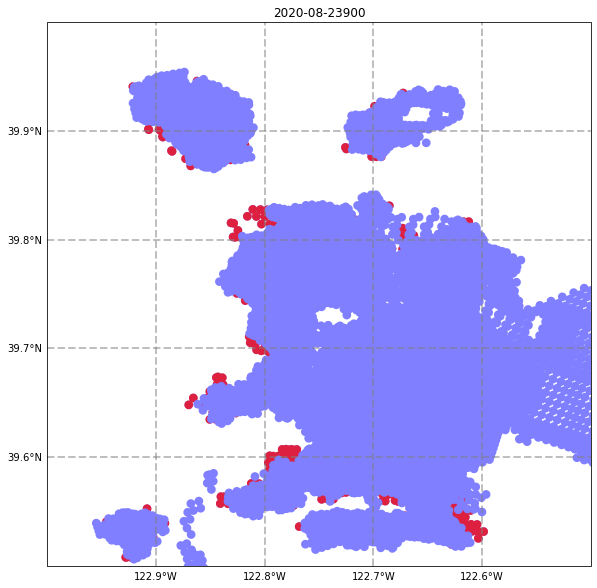

2020-08-23 906
REPEATS 17442 14522
0 17442
0
2020-08-23 948
REPEATS 17442 14522
0 17442
0
2020-08-23 954
REPEATS 18296 15093
854 18296
854


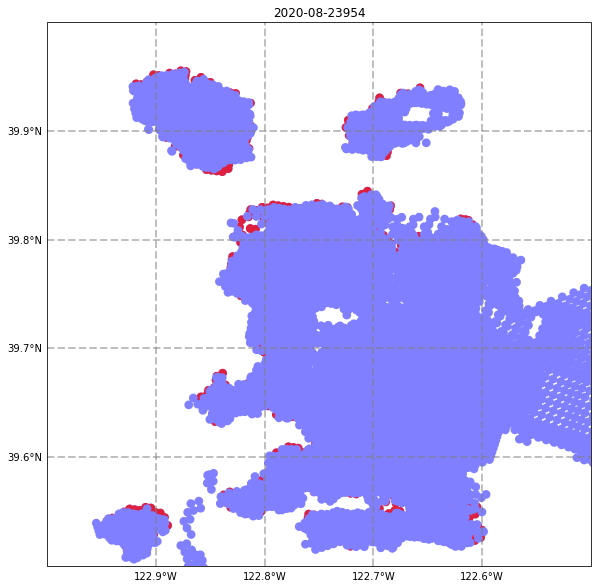

2020-08-23 1042
REPEATS 18806 15455
510 18806
510


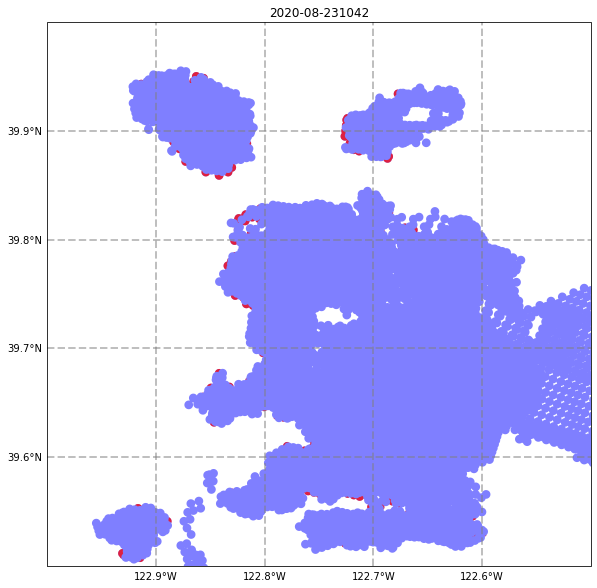

2020-08-23 1130
REPEATS 18806 15455
0 18806
0
2020-08-23 1842
REPEATS 18806 15455
0 18806
0
2020-08-23 1930
REPEATS 18806 15455
0 18806
0
2020-08-23 1936
REPEATS 18806 15455
0 18806
0
2020-08-23 2024
REPEATS 18988 15590
182 18988
182


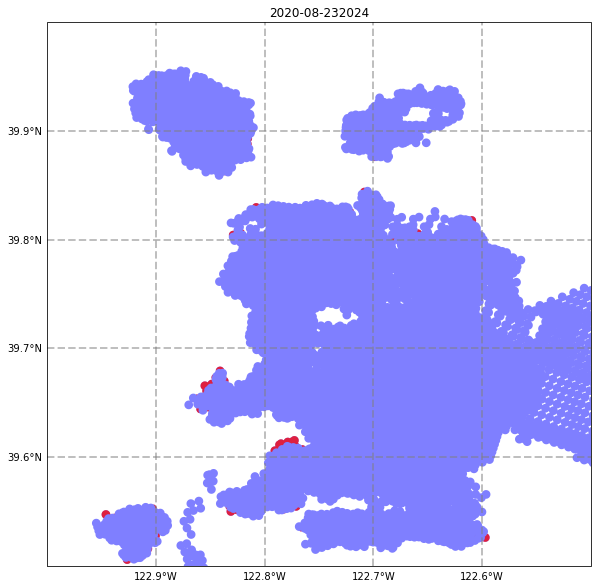

2020-08-23 2030
REPEATS 18988 15590
0 18988
0
2020-08-23 2112
REPEATS 19409 15874
421 19409
421


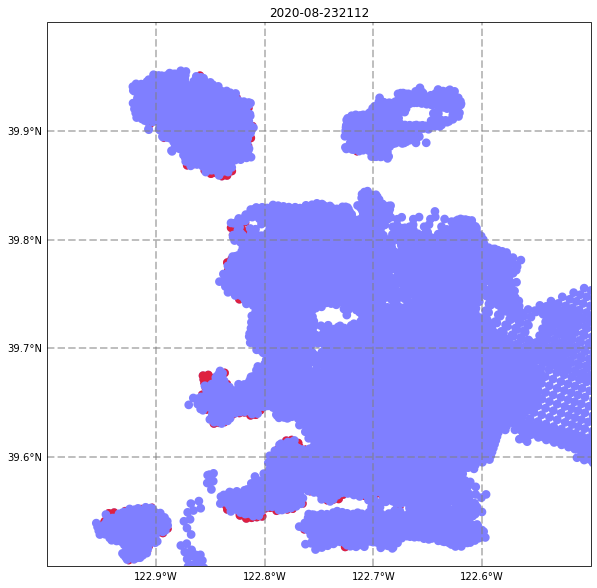

2020-08-23 2118
REPEATS 19409 15874
0 19409
0
2020-08-23 2206
REPEATS 19686 16067
277 19686
277


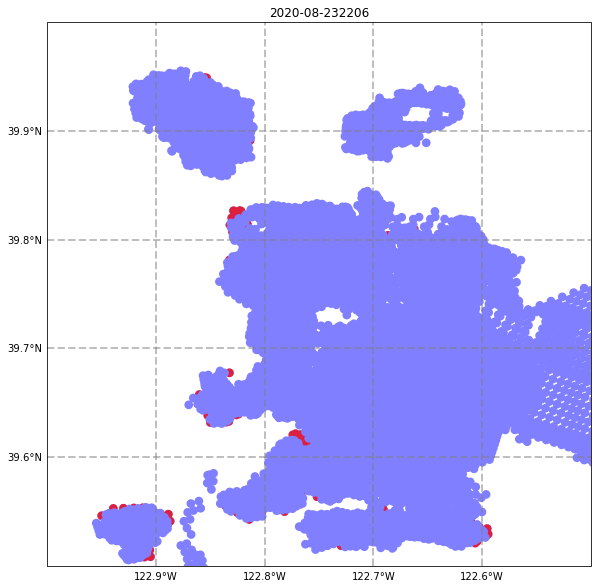

2020-08-24 748
REPEATS 19686 16067
0 19686
0
2020-08-24 754
REPEATS 19686 16067
0 19686
0
2020-08-24 842
REPEATS 19686 16067
0 19686
0
2020-08-24 848
REPEATS 19686 16067
0 19686
0
2020-08-24 930
REPEATS 19686 16067
0 19686
0
2020-08-24 936
REPEATS 19710 16085
24 19710
24
2020-08-24 1018
REPEATS 19710 16085
0 19710
0
2020-08-24 1024
REPEATS 19734 16101
24 19734
24
2020-08-24 1112
REPEATS 19735 16102
1 19735
1
2020-08-24 1830
REPEATS 19735 16102
0 19735
0
2020-08-24 1912
REPEATS 19735 16102
0 19735
0
2020-08-24 1918
REPEATS 19735 16102
0 19735
0
2020-08-24 2000
REPEATS 19735 16102
0 19735
0
2020-08-24 2006
REPEATS 19830 16168
95 19830
95
2020-08-24 2054
REPEATS 20087 16340
257 20087
257
2020-08-24 2100
REPEATS 20087 16340
0 20087
0
2020-08-24 2142
REPEATS 20087 16340
0 20087
0
2020-08-24 2148
REPEATS 20303 16489
216 20303
216
2020-08-25 736
REPEATS 20303 16489
0 20303
0
2020-08-25 824
REPEATS 20303 16489
0 20303
0
2020-08-25 912
REPEATS 20689 16756
386 20689
386
2020-08-25 918
REPEATS 20

REPEATS 43664 29413
409 43664
409
2020-09-03 2112
REPEATS 43664 29413
0 43664
0
2020-09-03 2200
REPEATS 43850 29502
186 43850
186
2020-09-04 742
REPEATS 43850 29502
0 43850
0
2020-09-04 748
REPEATS 43850 29502
0 43850
0
2020-09-04 836
REPEATS 43850 29502
0 43850
0
2020-09-04 924
REPEATS 44207 29665
357 44207
357
2020-09-04 930
REPEATS 44245 29678
38 44245
38
2020-09-04 1012
REPEATS 44245 29678
0 44245
0
2020-09-04 1018
REPEATS 44807 29936
562 44807
562
2020-09-04 1106
REPEATS 44986 30026
179 44986
179
2020-09-04 1906
REPEATS 44986 30026
0 44986
0
2020-09-04 1912
REPEATS 44986 30026
0 44986


Exception ignored in: <function BaseGeometry.__del__ at 0x7f20e8bc3ef0>
Traceback (most recent call last):
  File "/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/shapely/geometry/base.py", line 242, in __del__
    self.empty(val=None)
  File "/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/shapely/geometry/base.py", line 227, in empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 


0
2020-09-04 1954
REPEATS 44986 30026
0 44986
0
2020-09-04 2000
REPEATS 45248 30183
262 45248
262
2020-09-04 2048
REPEATS 45741 30475
493 45741


In [ ]:
fire_series_cumulative = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                'NEW FRP': np.nan*np.zeros(df_size),
                'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe

fire_series_new = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                'NEW FRP': np.nan*np.zeros(df_size),
                'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
count = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    lat_fire = incidents.iloc[ii]['Lat Fire']
    lon_fire = incidents.iloc[ii]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    
    for day in dates: #loop over the days
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        for over in overpasses: #loop over the overpasses
            print(day, over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            viirs_tups = [list((lon[i], lat[i])) for i in range(len(lat))]
            
            mp, poly_lats, poly_lons = build_today_polygon(pt_start, lat, lon, lat_old, lon_old, 0.2, 0)
            #add the new points to the old ones, and get the unique points
            lat_cumulative = np.append(lat_old, poly_lats)
            lon_cumulative = np.append(lon_old, poly_lons)
            print('REPEATS', len(lon_cumulative), len(np.unique(lon_cumulative)))
            poly_tups_new = [list((poly_lons[i], poly_lats[i])) for i in range(len(poly_lons))]
            poly_tups_cumulative = [list((lon_cumulative[i], lat_cumulative[i])) for i in range(len(lon_cumulative))]
            
            print(len(poly_tups_new), len(poly_tups_cumulative)) 
            
            #make a shape around the cumulative points, buffer by 300m (0.0027027 degrees ~0.003 degrees)
            shape_cumulative = MultiPoint(poly_tups_cumulative).buffer(0.004)#.convex_hull #the full shape so far
            

            #get indices and FRP from NEW points
            inds_new_points = [kk for kk in range(len(lat)) if viirs_tups[kk] in poly_tups_cumulative] #inds where we grab FRP
            print(len(inds_new_points))
            if len(inds_new_points)==0:
                frp=np.nan
            else:
                frp =  np.sum(viirs_over['frp'].iloc[inds_new_points])

            fire_series_cumulative.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_cumulative]
            
            if count==0:
                shape_new=shape_cumulative
            else:
                shape_new = shape_cumulative.difference(fire_series_cumulative['geometry'].iloc[count-1])
                
            fire_series_new.iloc[count] = [incidents['Incident Number'].iloc[ii],\
                                       incidents['Fire Name'].iloc[ii],\
                                       day, over, lat_fire, lon_fire, len(poly_tups_new),\
                                      frp, shape_new]

            if not shape_new.is_empty and count<100:
                #plot the shape so far, WHEN WE ADD
                fig = plt.figure(figsize=(15,10))
                ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
                #ax.set_extent([-124, -122, 39,41])
                ax.set_extent([-123, -122.5, 39.5, 40])
                gpd.GeoSeries(shape_cumulative).plot(ax=ax, color='b', alpha = 0.5)
                gpd.GeoSeries(shape_new).plot(ax=ax,color='r',alpha=0.75 )#
               # gpd.GeoSeries(mp).plot(ax=ax, color='gray', alpha = 0.15)
                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                plt.title(str(day)+str(over))
                plt.show()
            
            
            
            #re-assign for the next go round
            pt_start = shape_cumulative
            lat_old = lat_cumulative
            lon_old = lon_cumulative
            count=count+1
            
            
                
            
fire_series_new

In [ ]:
hi = fire_series['geometry']
hi
therest = fire_series[['Incident Number', 'Fire Name', 'Current Day','Current Overpass','Lat Fire', 'Lon Fire','Number of MODIS points', 'FRP']]
therest

fiona.supported_drivers
hi.to_file("august_complex_polygons_only_VIIRS_cumulative.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes_VIIRS_cumulative.csv')

In [76]:
fire_series_new.iloc[0:45]

,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,geometry
0,11843929.0,AUGUST COMPLEX,2020-08-18,800.0,39.659444,-122.808889,0.0,NaN,"POLYGON ((-122.80489 39.65944, -122.80491 39.6..."
1,11843929.0,AUGUST COMPLEX,2020-08-18,806.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY
2,11843929.0,AUGUST COMPLEX,2020-08-18,854.0,39.659444,-122.808889,12.0,41.89,"MULTIPOLYGON (((-122.67211 39.75618, -122.6719..."
3,11843929.0,AUGUST COMPLEX,2020-08-18,900.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY
4,11843929.0,AUGUST COMPLEX,2020-08-18,942.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY
5,11843929.0,AUGUST COMPLEX,2020-08-18,948.0,39.659444,-122.808889,43.0,94.50,"MULTIPOLYGON (((-122.66857 39.75680, -122.6685..."
6,11843929.0,AUGUST COMPLEX,2020-08-18,1036.0,39.659444,-122.808889,14.0,49.86,"MULTIPOLYGON (((-122.67478 39.74865, -122.6748..."
7,11843929.0,AUGUST COMPLEX,2020-08-18,1124.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY
8,11843929.0,AUGUST COMPLEX,2020-08-18,1836.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY
9,11843929.0,AUGUST COMPLEX,2020-08-18,1842.0,39.659444,-122.808889,0.0,NaN,POLYGON EMPTY


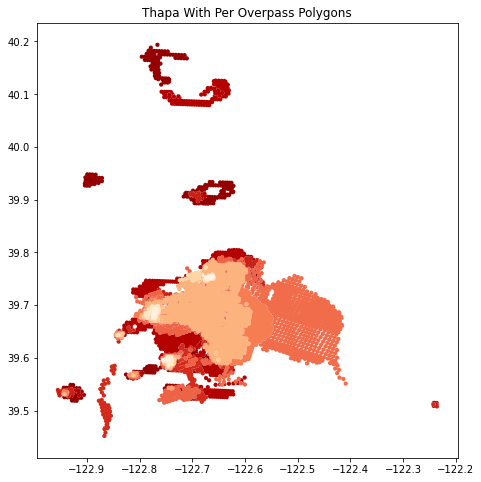

In [77]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
fire_series_new.iloc[0:39].plot( ax=ax, cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

## Check difference of new and old polygons

In [ ]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('august_complex_polygons_only_VIIRS_cumulative.geojson') #polygons only
fire_attributes = pd.read_csv('august_complex_polygons_attributes_VIIRS_cumulative.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];
print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa_att))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, pd.DataFrame({'DateTim':datestrings}), ac_thapa_poly], axis=1))
ac_thapa

In [ ]:
diff_geom = gpd.GeoDataFrame({'geometry': np.nan*np.zeros(len(ac_thapa))})
for ii in range(len(ac_thapa)):
    if ii==0:
        diff_geom['geometry'].iloc[ii] = ac_thapa['geometry'].iloc[ii]
    else:
        diff_geom['geometry'].iloc[ii] = ac_thapa['geometry'].iloc[ii].difference(ac_thapa['geometry'].iloc[ii-1])
        

diff_geom = gpd.GeoDataFrame(pd.concat([ac_thapa_att, pd.DataFrame({'DateTim':datestrings}), diff_geom], axis=1))
diff_geom

In [ ]:
for ii in range(len(diff_geom)):
    shape_cumulative = diff_geom['geometry'].iloc[ii]
    if not shape_cumulative.is_empty:
        print(shape_cumulative)
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        gpd.GeoSeries(shape_cumulative).plot(ax=ax)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        plt.title(str(diff_geom['DateTim'].iloc[ii]))
        plt.show()

In [ ]:
hi = diff_geom['geometry']
hi
therest = diff_geom[['Incident Number', 'Fire Name', 'Current Day','Current Overpass','Lat Fire', 'Lon Fire','Number of NEW VIIRS points', 'NEW FRP']]
therest

fiona.supported_drivers
hi.to_file("august_complex_polygons_only_VIIRS_difference.geojson", driver='GeoJSON')
therest.to_csv('august_complex_polygons_attributes_VIIRS_difference.csv')

# Helper Function

In [6]:
#lat_old and lon_old are the detects used to build the prev version of today's polygon
def build_today_polygon(shape, lats, lons, lat_old, lon_old, bf, plot_evol):
    shape_buff = shape.buffer(bf)
    
    #find the points that are inside the buffer
    #lat_new = np.nan*np.zeros(len(lats))
    #lon_new = np.nan*np.zeros(len(lons))
    i = 0
    pairs = zip(lons, lats)

    xs, ys = shape_buff.exterior.xy #get the edges of the buffered shape
    poly_path = Path(np.stack([xs, ys], axis=1)) #make them into a path
    poly_path_contains = poly_path.contains_points(np.stack([lons,lats],axis=1)) #get the points that are in the shape REPLACES FOR LOOP
    #print(lat[np.where(poly_path_contains==True)[0]])
    
    #for pair in zip(lons, lats):
    #    pt_check = Point(pair)
    #    if shape_buff.contains(pt_check):
    #        #add the point to the list
    #        lat_new[i] = pair[1]
    #        lon_new[i] = pair[0]
    #        i = i+1
    #grab the new points
    lat_new = lats[np.where(poly_path_contains==True)[0]]
    lon_new = lons[np.where(poly_path_contains==True)[0]]
    #lat_new = lat_new[np.where(~np.isnan(lat_new))]
    #lon_new = lon_new[np.where(~np.isnan(lon_new))]
    #make a shape around them
    tups = [list((lon_new[i], lat_new[i])) for i in range(len(lat_new))]
    mp = MultiPoint(tups).convex_hull
    
    if plot_evol == 1: #plot the new polygon
        print(len(lat_new), len(lon_new))
        m = gpd.GeoSeries(mp)
        m.plot()
        plt.scatter(lon_new, lat_new, c = 'k')
        plt.scatter(lon_fire, lat_fire, c='r')
        plt.title('Updated shape and points')
        plt.show()
    
    if (len(lat_new)-len(lat_old))>0: #if we are adding points
        print('Time for recursive call')
        return build_today_polygon(mp, lats, lons, lat_new, lon_new, bf, plot_evol)
    else:
        return mp, lat_new, lon_new #MAY WANT TO RETURN A BUFFERED VERSION OF THE POLYGON

## Code Testing

In [ ]:
fire_series = gpd.GeoDataFrame({'Incident Number': np.nan*np.zeros(df_size), 
                          'Fire Name': np.nan*np.zeros(df_size), 
                         'Current Day': np.nan*np.zeros(df_size),
                        'Current Overpass': np.nan*np.zeros(df_size),
                        'Lat Fire': np.nan*np.zeros(df_size), 
                     'Lon Fire': np.nan*np.zeros(df_size), 
                         'Number of NEW VIIRS points': np.nan*np.zeros(df_size), 
                                'NEW FRP': np.nan*np.zeros(df_size),
            'geometry': np.nan*np.zeros(df_size)}) # pre-allocate the dataframe
count = 0
for ii in range(len(incidents)):
    #start and end times of the fire in UTC
    inci_start = np.datetime64(incidents['First Day'].iloc[0]) + np.timedelta64(7,'h')
    inci_end = np.datetime64(incidents['Last Day'].iloc[0]) + np.timedelta64(7,'h')
    
    lat_fire = incidents.iloc[ii]['Lat Fire']
    lon_fire = incidents.iloc[ii]['Lon Fire']
    print(lon_fire, lat_fire)
    pt_start = Point(lon_fire, lat_fire)
    pt_start = pt_start.buffer(0.04)
    lat_old = np.array([lat_fire])
    lon_old = np.array([lon_fire])
    
    #how many overpass times are between the start and end time of this fire?
    inds_fire = np.where((viirs_all['acq_date'].iloc[:]>=str(inci_start))\
                                   & (viirs_all['acq_date'].iloc[:]<=str(inci_end)))[0]
    viirs_fire = viirs_all.iloc[inds_fire]
    dates = np.unique(viirs_fire['acq_date'])
    
    for day in dates[0:1]: #loop over the days
        viirs_day = viirs_fire.iloc[np.where(viirs_fire['acq_date']==day)[0]]
        overpasses = np.unique(viirs_day['acq_time'])
        for over in overpasses[0:4]: #loop over the overpasses
            print(day, over)
            viirs_over = viirs_day.iloc[np.where(viirs_day['acq_time']==over)[0]] # all points associated with an overpass
            lat = viirs_over['latitude'].values
            lon = viirs_over['longitude'].values
            
            print(len(lat), len(lon))
            
            xs, ys = pt_start.buffer(0.2).exterior.xy
            #print(np.stack([xs, ys], axis=1))
            poly_path = Path(np.stack([xs, ys], axis=1))
            poly_path_contains = poly_path.contains_points(np.stack([lon,lat],axis=1))
            print(len(lat[np.where(poly_path_contains==True)[0]]))

            
            
               
#fire_series